# Домашнее задание к лекции «Feature Selection»

In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn import linear_model

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Загрузим данные и посмотрим на них:

In [307]:
data = pd.read_csv('Kobe.csv')

data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [308]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Пропуски есть только в целевой переменной shot_made_flag, удаляем их

In [309]:
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

Посмотрим на целевую переменную. Она принимает два значения: 0 и 1 (попал/не попал)

In [310]:
data.shot_made_flag.value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

<AxesSubplot:>

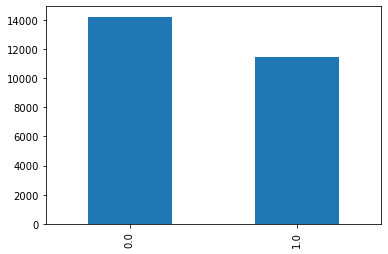

In [311]:
data.shot_made_flag.value_counts().plot(kind='bar')

Теперь попробуем отдельно рассмотреть каждую переменную

In [312]:
# Вспомогательные функции

def count_encoder(X, cols):
    for col in cols:
        mapping = {}
        
        for value, count in X[col].value_counts(normalize=True).iteritems():
            mapping[value] = round(count, 2)

        X[col] = X[col].apply(lambda x: mapping[x])
    return X
    
def one_hot_encoder(X, cols):
    for col in cols:
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=False)
        X_format = pd.concat([X, dummies], axis=1)
    return X_format       

<b>action_type</b>: здесь довольно большой список типов, есть достаточно редкие. У меня есть 2 варинта: 

- применить к столбцу OneHotEncoding, но перед этим все редкие метки (< 10) заменить на общий тип Other Shots
- применить к столбцу CountEncoding, то есть заменить категориальные переменные, на их долю в дота-сете

Попробуем второй вариант

In [313]:
data.action_type.value_counts()

Jump Shot                          15836
Layup Shot                          2154
Driving Layup Shot                  1628
Turnaround Jump Shot                 891
Fadeaway Jump Shot                   872
Running Jump Shot                    779
Pullup Jump shot                     402
Turnaround Fadeaway shot             366
Slam Dunk Shot                       334
Reverse Layup Shot                   333
Jump Bank Shot                       289
Driving Dunk Shot                    257
Dunk Shot                            217
Tip Shot                             151
Step Back Jump shot                  106
Alley Oop Dunk Shot                   95
Floating Jump shot                    93
Driving Reverse Layup Shot            83
Hook Shot                             73
Driving Finger Roll Shot              68
Alley Oop Layup shot                  67
Reverse Dunk Shot                     61
Driving Finger Roll Layup Shot        59
Turnaround Bank shot                  58
Running Layup Sh

In [314]:
count_encoder(data, ['action_type']).head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,0.62,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,0.62,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,0.62,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,0.01,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,0.62,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


<b>combined_shot_type</b> Здесь всего 6 уникальных значений, сделаем OneHotEncoding

In [315]:
data.combined_shot_type.value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

<b>game_event_id и game_id</b> не смотря на числовое значение являются по сути категориальными.

С одной стороны мне кажется полезным понимать, например, какое кол-во бросков игрок сделал в этой игре или в этом чемпионате. Это может влиять, например, на его спортивную форму. С другой стороны кол-во бросков и результативность не одно и тоже. Я удаляю эти признаки

In [316]:
data.game_event_id.value_counts()

2      105
4       85
11      81
17      81
6       78
      ... 
590      1
606      1
625      1
593      1
639      1
Name: game_event_id, Length: 618, dtype: int64

In [317]:
data.game_id.value_counts()

21501228    43
20601081    41
20500591    39
20200069    39
20700553    37
            ..
29600027     1
20400518     1
29600767     1
29700933     1
29600202     1
Name: game_id, Length: 1558, dtype: int64

In [318]:
data.drop(['game_event_id', 'game_id'], axis=1, inplace=True)

<b>lat, lon, loc_x, loc_y</b>: Числовые переменные, связанные с координатами на поле пока пропускаем

<b>minutes_remaining, seconds_remaining</b>: Минуты и секунды до конца периода. Отдельно в них нет особого смысла, добавим новый признак period_remining, который будет содержать общее кол-во секунд.
Также, возможно, имеет смысл использовать эти признаки вместе с периодом и вычислить, например, время до конца игры (но в целях экономии времени я сейчас не буду углубляться в мат.часть:) 

In [319]:
data.minutes_remaining.describe()

count    25697.000000
mean         4.886796
std          3.452475
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: minutes_remaining, dtype: float64

In [320]:
data.seconds_remaining.describe()

count    25697.000000
mean        28.311554
std         17.523392
min          0.000000
25%         13.000000
50%         28.000000
75%         43.000000
max         59.000000
Name: seconds_remaining, dtype: float64

In [321]:
data['period_remining'] = data.minutes_remaining * 60 + data.seconds_remaining

data[['minutes_remaining', 'seconds_remaining', 'period_remining']].head()

,minutes_remaining,seconds_remaining,period_remining
1,10,22,622
2,7,45,465
3,6,52,412
4,6,19,379
5,9,32,572


In [322]:
data.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

<b>period и playoffs</b> оставляем как есть, выбросов нет

In [323]:
data.period.value_counts()

3    7002
1    6700
4    6043
2    5635
5     280
6      30
7       7
Name: period, dtype: int64

In [324]:
data.playoffs.value_counts()

0    21939
1     3758
Name: playoffs, dtype: int64

<b>season</b> В таком виде признак вряд ли может быть полезен. Сделаем из него новый признак season_year (для этого возьмём только год начала сезона, так как год окончания это просто +1)

In [325]:
data.season.value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

In [326]:
data['season_year'] = data.apply(lambda x: x['season'].split('-')[0], axis=1)

data['season_year'] = data['season_year'].astype('int64')

In [327]:
data.drop(['season'], axis=1, inplace=True)

<b>shot_distance</b> оставляем как есть, выбросов нет

In [328]:
data.shot_distance.describe()

count    25697.000000
mean        13.457096
std          9.388725
min          0.000000
25%          5.000000
50%         15.000000
75%         21.000000
max         79.000000
Name: shot_distance, dtype: float64

<b>shot_type</b> Тут всего 2 типа Field Goal, будем заменять на 0/1

In [329]:
data.shot_type.value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

In [330]:
data.shot_type.replace(to_replace={'2PT Field Goal': 0, '3PT Field Goal': 1}, inplace=True)

<b>shot_zone_area и shot_zone_basic</b> Здесь немного уникальных значений, сделаем OneHotEncoding

In [331]:
data.shot_zone_area.value_counts()

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64

In [332]:
data.shot_zone_basic.value_counts()

Mid-Range                10532
Restricted Area           5932
Above the Break 3         4720
In The Paint (Non-RA)     3880
Right Corner 3             333
Left Corner 3              240
Backcourt                   60
Name: shot_zone_basic, dtype: int64

<b>shot_zone_range</b> Здесь напрашивается новый порядковый признак. Back Court Shot - это удар с "тыловой" стороны поля, то есть издалека, поэтому его значение максимально

In [333]:
data.shot_zone_range.value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

In [334]:
shot_zone_map={'Less Than 8 ft.': 0, '8-16 ft.': 1, '16-24 ft.': 2, '24+ ft.': 3, 'Back Court Shot': 4 }

data.shot_zone_range.replace(to_replace=shot_zone_map, inplace=True)

<b>team_id и team_name</b>: Бесполезные признак, все броски сделаны за одну команду, удаляем

In [335]:
data.team_id.value_counts()

1610612747    25697
Name: team_id, dtype: int64

In [336]:
data.team_name.value_counts()

Los Angeles Lakers    25697
Name: team_name, dtype: int64

In [337]:
data.drop(['team_id', 'team_name'], axis=1, inplace=True)

<b>game_date</b> Дата игры. Сама по себе она даёт немного (с учётом того, что у нас уже есть id игры). Но из неё можно сделать другие признаки, я буду использовать месяц, день недели и день в году. Особого смысла использовать год нет, так как у нас есть год начала сезона (год игры либо равен, либо +1)

In [338]:
data['game_date_format'] = pd.to_datetime(data['game_date'])
data['game_month'] = data['game_date_format'].dt.month
data['day_of_week'] = data['game_date_format'].dt.dayofweek
data['day_of_year'] = data['game_date_format'].dt.dayofyear

In [339]:
data.drop(['game_date_format', 'game_date'], axis=1, inplace=True)

<b>matchup</b> здесь мы видим разные пары соперников, они повторяются, есть разница в разделителе. На первый взгляд кажется, что эти данные лишние (по нашим данным Коби всегда играл за Лосанжелес, а данные по команде соперника есть в следующей колонке).
Но остаётся вопрос почему такой странный вид данных. Проверим гипотезу, что разделитель отличается для игр дома/в гостях.
Создадим новый признак game_home равный 0 если разделитель @ и 1 если vs.

In [340]:
data.matchup.value_counts()

LAL @ SAS      853
LAL vs. SAS    765
LAL @ PHX      751
LAL @ SAC      751
LAL vs. HOU    722
LAL vs. PHX    721
LAL @ DEN      712
LAL @ HOU      677
LAL @ POR      676
LAL vs. SAC    646
LAL vs. DEN    640
LAL @ UTA      617
LAL vs. POR    616
LAL @ MIN      615
LAL vs. UTA    606
LAL vs. MIN    604
LAL @ GSW      585
LAL vs. GSW    558
LAL vs. LAC    548
LAL @ DAL      534
LAL @ LAC      526
LAL vs. DAL    499
LAL vs. MEM    444
LAL @ BOS      432
LAL @ MEM      427
LAL @ SEA      366
LAL vs. BOS    351
LAL vs. IND    348
LAL @ ORL      347
LAL vs. SEA    328
LAL @ PHI      327
LAL @ DET      309
LAL vs. OKC    298
LAL vs. NYK    289
LAL @ TOR      286
LAL vs. MIA    278
LAL @ IND      278
LAL vs. DET    278
LAL @ NYK      277
LAL @ WAS      277
LAL @ CLE      276
LAL vs. PHI    276
LAL vs. TOR    270
LAL @ OKC      263
LAL @ CHI      261
LAL vs. MIL    260
LAL vs. ORL    257
LAL vs. CHI    255
LAL @ ATL      249
LAL @ MIL      247
LAL @ MIA      239
LAL vs. NOH    238
LAL vs. CLE 

In [341]:
data.matchup = data.matchup.apply(lambda x: 0 if (x.find('@') != -1) else 1)

<b>opponent</b> Здесь представлены команды соперника, их довольно много, тем не менее мне кажется лучшим вариантом будет OneHotEncoding (но придётся снижать размерность)

In [342]:
data.opponent.value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

<b>shot_id</b> Это просто идентификатор: удаляем

In [343]:
data.drop(['shot_id'], axis=1, inplace=True)

Перед тем, как делать OneHotEncoding посмотрим корреляцию тех количественных признаков, которые уже есть

In [344]:
data.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,period_remining,season_year,game_month,day_of_week,day_of_year
1,0.62,Jump Shot,34.0443,-157,0,-118.4268,1,0,15,0.0,0,Left Side(L),Mid-Range,1,0,POR,622,2000,10,1,305
2,0.62,Jump Shot,33.9093,-101,135,-118.3708,1,0,16,1.0,0,Left Side Center(LC),Mid-Range,2,0,POR,465,2000,10,1,305
3,0.62,Jump Shot,33.8693,138,175,-118.1318,1,0,22,0.0,0,Right Side Center(RC),Mid-Range,2,0,POR,412,2000,10,1,305
4,0.01,Dunk,34.0443,0,0,-118.2698,2,0,0,1.0,0,Center(C),Restricted Area,0,0,POR,379,2000,10,1,305
5,0.62,Jump Shot,34.0553,-145,-11,-118.4148,3,0,14,0.0,0,Left Side(L),Mid-Range,1,0,POR,572,2000,10,1,305


In [345]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  float64
 1   combined_shot_type  25697 non-null  object 
 2   lat                 25697 non-null  float64
 3   loc_x               25697 non-null  int64  
 4   loc_y               25697 non-null  int64  
 5   lon                 25697 non-null  float64
 6   period              25697 non-null  int64  
 7   playoffs            25697 non-null  int64  
 8   shot_distance       25697 non-null  int64  
 9   shot_made_flag      25697 non-null  float64
 10  shot_type           25697 non-null  int64  
 11  shot_zone_area      25697 non-null  object 
 12  shot_zone_basic     25697 non-null  object 
 13  shot_zone_range     25697 non-null  int64  
 14  matchup             25697 non-null  int64  
 15  opponent            25697 non-null  object 
 16  peri

In [346]:
data.corr()

,action_type,lat,loc_x,loc_y,lon,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_range,matchup,period_remining,season_year,game_month,day_of_week,day_of_year
action_type,1.000000,-0.517058,0.035131,0.517058,0.035131,0.019675,0.005669,0.662149,-0.311879,0.373659,0.627006,-0.014061,-0.011858,-0.052321,-0.004717,0.015254,-0.004924
lat,-0.517058,1.000000,0.017578,-1.000000,0.017578,-0.039737,-0.000857,-0.818124,0.148070,-0.606221,-0.770084,-0.006805,0.081826,-0.096691,0.005204,-0.008643,0.005553
loc_x,0.035131,0.017578,1.000000,-0.017578,1.000000,-0.030059,-0.007751,0.022307,-0.000848,-0.006003,0.025631,-0.011743,0.006714,0.005457,-0.007749,0.009129,-0.007703
loc_y,0.517058,-1.000000,-0.017578,1.000000,-0.017578,0.039737,0.000857,0.818124,-0.148070,0.606221,0.770084,0.006805,-0.081826,0.096691,-0.005204,0.008643,-0.005553
lon,0.035131,0.017578,1.000000,-0.017578,1.000000,-0.030059,-0.007751,0.022307,-0.000848,-0.006003,0.025631,-0.011743,0.006714,0.005457,-0.007749,0.009129,-0.007703
period,0.019675,-0.039737,-0.030059,0.039737,-0.030059,1.000000,0.003905,0.047311,-0.032152,0.082083,0.056836,-0.020769,-0.046157,-0.020712,-0.018274,0.000668,-0.019089
playoffs,0.005669,-0.000857,-0.007751,0.000857,-0.007751,0.003905,1.000000,-0.007751,-0.001257,-0.013631,-0.012801,-0.008559,0.009029,-0.077761,-0.061754,0.031708,-0.061500
shot_distance,0.662149,-0.818124,0.022307,0.818124,0.022307,0.047311,-0.007751,1.000000,-0.198242,0.668282,0.957667,-0.043032,-0.068501,0.111624,-0.012793,0.001383,-0.012966
shot_made_flag,-0.311879,0.148070,-0.000848,-0.148070,-0.000848,-0.032152,-0.001257,-0.198242,1.000000,-0.121462,-0.180075,0.020155,0.030775,-0.018777,-0.004293,-0.000764,-0.004120
shot_type,0.373659,-0.606221,-0.006003,0.606221,-0.006003,0.082083,-0.013631,0.668282,-0.121462,1.000000,0.740202,-0.021281,-0.122936,0.095649,-0.009674,-0.003178,-0.009156


<AxesSubplot:>

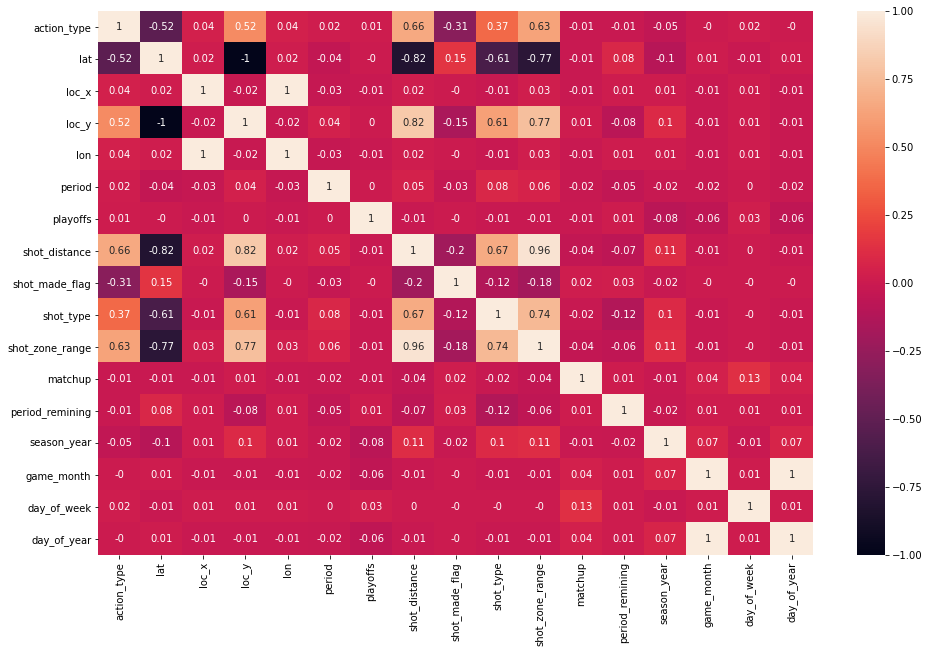

In [347]:
plt.figure(figsize=(16, 10))
sns.heatmap(data.corr().round(2), annot=True)

По тепловой карте мы видим, что некоторые признаки имеют 100% корреляцию: lat и loc_y, lon и loc_x. Таким образом, в каждой паре можно оставить только один признак, второй не даст больше информации. Оставим loc_y и loc_x (просто потому, что они целые)

Также есть ожидаемо сильная корреляция координат с дистанцией броска shot_distance. Пока оставим.

In [348]:
data.drop(['lat', 'lon'], axis=1, inplace=True)

Делаем OneHotEncoding

In [349]:
df = one_hot_encoder(data, ['combined_shot_type', 'shot_zone_area', 'shot_zone_basic', 'opponent'])

df.drop(['combined_shot_type', 'shot_zone_area', 'shot_zone_basic', 'opponent'], axis=1, inplace=True)

In [350]:
df.head()

,action_type,loc_x,loc_y,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_range,matchup,period_remining,season_year,game_month,day_of_week,day_of_year,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,0.62,-157,0,1,0,15,0.0,0,1,0,622,2000,10,1,305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.62,-101,135,1,0,16,1.0,0,2,0,465,2000,10,1,305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.62,138,175,1,0,22,0.0,0,2,0,412,2000,10,1,305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.01,0,0,2,0,0,1.0,0,0,0,379,2000,10,1,305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0.62,-145,-11,3,0,14,0.0,0,1,0,572,2000,10,1,305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   action_type      25697 non-null  float64
 1   loc_x            25697 non-null  int64  
 2   loc_y            25697 non-null  int64  
 3   period           25697 non-null  int64  
 4   playoffs         25697 non-null  int64  
 5   shot_distance    25697 non-null  int64  
 6   shot_made_flag   25697 non-null  float64
 7   shot_type        25697 non-null  int64  
 8   shot_zone_range  25697 non-null  int64  
 9   matchup          25697 non-null  int64  
 10  period_remining  25697 non-null  int64  
 11  season_year      25697 non-null  int64  
 12  game_month       25697 non-null  int64  
 13  day_of_week      25697 non-null  int64  
 14  day_of_year      25697 non-null  int64  
 15  opponent_ATL     25697 non-null  uint8  
 16  opponent_BKN     25697 non-null  uint8  
 17  opponent_BOS

Скалируем наши данные:

In [352]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scale = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scale.head()

,action_type,loc_x,loc_y,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_range,matchup,period_remining,season_year,game_month,day_of_week,day_of_year,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
0,1.000000,0.186747,0.052695,0.000000,0.0,0.189873,0.0,0.0,0.25,0.0,0.871148,0.210526,0.818182,0.166667,0.835165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.299197,0.214371,0.000000,0.0,0.202532,1.0,0.0,0.50,0.0,0.651261,0.210526,0.818182,0.166667,0.835165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.779116,0.262275,0.000000,0.0,0.278481,0.0,0.0,0.50,0.0,0.577031,0.210526,0.818182,0.166667,0.835165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016129,0.502008,0.052695,0.166667,0.0,0.000000,1.0,0.0,0.00,0.0,0.530812,0.210526,0.818182,0.166667,0.835165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.210843,0.039521,0.333333,0.0,0.177215,0.0,0.0,0.25,0.0,0.801120,0.210526,0.818182,0.166667,0.835165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Приступим к обучению моделей

In [353]:
X = df_scale.drop(['shot_made_flag'], axis=1)
y = df_scale.shot_made_flag

In [354]:
from sklearn.metrics import roc_auc_score

def fit_model(X, y, params={}, type_model='linear', random_seed=42):
    
    if type_model == 'linear':
        model = linear_model.LinearRegression(**params)    
        
    if type_model == 'lasso':
        model = linear_model.Lasso(**params) 
        
    if type_model == 'ridge':
        model = linear_model.Ridge(**params)           
    
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
    
    model.fit(X_train, y_train)
    
    pred_values_train = model.predict(X_train)
    pred_values_test = model.predict(X_test)
    
    print('TRAIN')  
    print('roc_auc: {}'.format(roc_auc_score(y_train, pred_values_train)))    
    print()
    print('TEST')
    print('roc_auc: {}'.format(roc_auc_score(y_test, pred_values_test))) 
    
    return model.coef_, model.intercept_

In [355]:
linear_coef, linear_intersept = fit_model(X, y)

TRAIN
roc_auc: 0.6825171399767078

TEST
roc_auc: 0.6699272052340668


In [356]:
linear_coef, linear_intersept

(array([-0.36701083,  0.01434033,  0.12670946, -0.06991757, -0.00729398,
        -0.49448385, -0.05550043,  0.28171072,  0.01610506,  0.04399134,
        -0.0642803 ,  0.03564459,  0.00679219, -0.05017582, -0.01302613,
        -0.0467948 , -0.01183654,  0.00889989,  0.01043868, -0.03431627,
         0.01357651,  0.01571525,  0.01424618, -0.00791515, -0.01504788,
        -0.03904985,  0.0073946 , -0.02243421, -0.0130416 , -0.01308786,
        -0.00557561, -0.0204554 ,  0.01613961,  0.00853251,  0.03990118,
        -0.04377261, -0.00149447,  0.03334433,  0.05365384,  0.00453551,
         0.03036862, -0.01506293,  0.02917665, -0.00953948,  0.00391759,
         0.01443745,  0.00817238]),
 0.6734719410022625)

In [357]:
lasso_coef, lasso_intersept = fit_model(X, y, type_model='lasso', params={'alpha': 0.01})

TRAIN
roc_auc: 0.6693715080526009

TEST
roc_auc: 0.6613839187929614


In [358]:
lasso_coef, lasso_intersept

(array([-0.29514056,  0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        , -0.        , -0.        ,
         0.        , -0.        ]),
 0.6345838927585388)

In [359]:
ridge_coef, ridge_intersept = fit_model(X, y, type_model='ridge', params={'alpha': 1})

TRAIN
roc_auc: 0.682577637616437

TEST
roc_auc: 0.6699054036625687


In [360]:
ridge_coef, ridge_intersept

(array([-0.36739992,  0.01430348,  0.11712889, -0.06974549, -0.00730049,
        -0.45646645, -0.05413993,  0.26788406,  0.01617453,  0.04412802,
        -0.06430076,  0.0293376 ,  0.00681452, -0.04334147, -0.01301969,
        -0.04533947, -0.01187818,  0.00889974,  0.01042742, -0.03440679,
         0.0135248 ,  0.0156472 ,  0.01422885, -0.00793987, -0.01500466,
        -0.03914673,  0.00741344, -0.0223684 , -0.01299077, -0.01313594,
        -0.00559048, -0.02045227,  0.01600148,  0.00847473,  0.03974116,
        -0.0438454 , -0.00150872,  0.03315539,  0.05357045,  0.0044646 ,
         0.03032944, -0.01510784,  0.02905765, -0.00962386,  0.00392554,
         0.01445537,  0.0080418 ]),
 0.6729549056340085)

Теперь построим графики

In [361]:
linear_coef_df = pd.DataFrame(linear_coef, index=X.columns, columns=['coef'])

linear_coef_df.head()

,coef
action_type,-0.367011
loc_x,0.014340
loc_y,0.126709
period,-0.069918
playoffs,-0.007294


In [362]:
lasso_coef_df = pd.DataFrame(lasso_coef, index=X.columns, columns=['coef'])

lasso_coef_df.head()

,coef
action_type,-0.295141
loc_x,0.000000
loc_y,-0.000000
period,-0.000000
playoffs,-0.000000


In [363]:
ridge_coef_df = pd.DataFrame(ridge_coef, index=X.columns, columns=['coef'])

ridge_coef_df.head()

,coef
action_type,-0.367400
loc_x,0.014303
loc_y,0.117129
period,-0.069745
playoffs,-0.007300


<ipython-input-364-c40f3d49b8fb>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation = 45, ha="right")


[Text(0, 0, 'action_type'),
 Text(1, 0, 'loc_x'),
 Text(2, 0, 'loc_y'),
 Text(3, 0, 'period'),
 Text(4, 0, 'playoffs'),
 Text(5, 0, 'shot_distance'),
 Text(6, 0, 'shot_type'),
 Text(7, 0, 'shot_zone_range'),
 Text(8, 0, 'matchup'),
 Text(9, 0, 'period_remining'),
 Text(10, 0, 'season_year'),
 Text(11, 0, 'game_month'),
 Text(12, 0, 'day_of_week'),
 Text(13, 0, 'day_of_year'),
 Text(14, 0, 'opponent_ATL'),
 Text(15, 0, 'opponent_BKN'),
 Text(16, 0, 'opponent_BOS'),
 Text(17, 0, 'opponent_CHA'),
 Text(18, 0, 'opponent_CHI'),
 Text(19, 0, 'opponent_CLE'),
 Text(20, 0, 'opponent_DAL'),
 Text(21, 0, 'opponent_DEN'),
 Text(22, 0, 'opponent_DET'),
 Text(23, 0, 'opponent_GSW'),
 Text(24, 0, 'opponent_HOU'),
 Text(25, 0, 'opponent_IND'),
 Text(26, 0, 'opponent_LAC'),
 Text(27, 0, 'opponent_MEM'),
 Text(28, 0, 'opponent_MIA'),
 Text(29, 0, 'opponent_MIL'),
 Text(30, 0, 'opponent_MIN'),
 Text(31, 0, 'opponent_NJN'),
 Text(32, 0, 'opponent_NOH'),
 Text(33, 0, 'opponent_NOP'),
 Text(34, 0, 'opponen

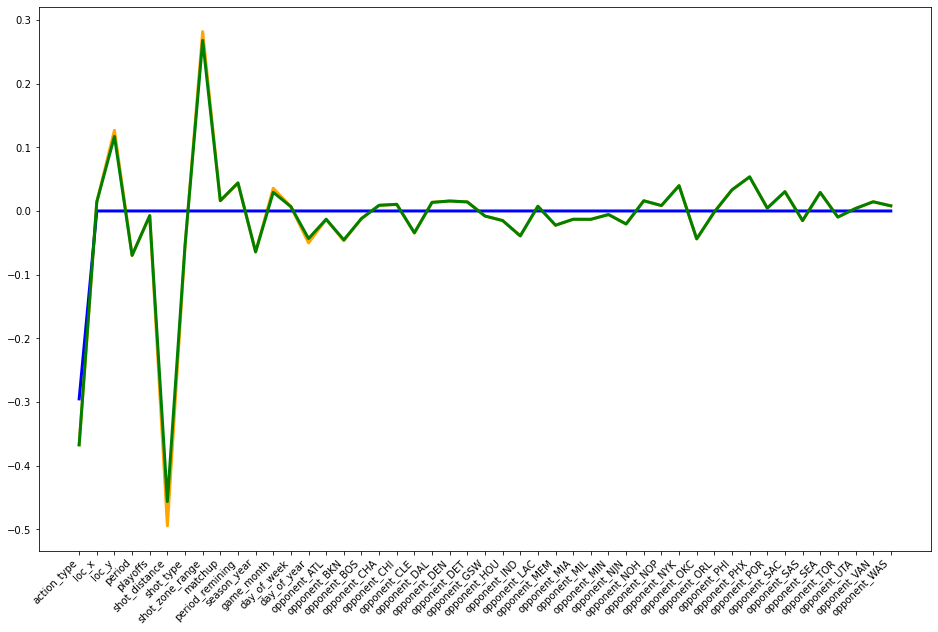

In [364]:
fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(16)

line1=ax.plot(linear_coef_df, c="orange", linewidth=3, label="linear_coef_df")
line2=ax.plot(lasso_coef_df, c="blue", linewidth=3, label="lasso_coef_df")
line3=ax.plot(ridge_coef_df, c="green", linewidth=3, label="ridge_coef_df")

ax.set_xticklabels(X.columns, rotation = 45, ha="right")

По коэффициентам и графику видно, что:
- Лассо обнулило все коэффициенты, кроме action_type
- Обычная линейная регрессия и ridge отработали почти одинкаво, максимальный коэфф. у short-type

В целом у меня получилось очень низкое качество

<b>Вопросы: 
    
    - Такое вообще возможно? Я думала, что ridge тоже должен обнулять коэффициенты. Или я неправильно настроила эту модель?
    
    - В итоговом ответе я использую minMaxScaler, это даёт более читаемые коэф-ты на моделях. Например, если использовать стандартный, коэф-ты у линейной модели и у ridge будут другие (но всё равно очень близко), а у Лассо будет несколько ненулевых коэф-тов. Где можно почитать, как правильно выбирать скейлеры?

</b>

Теперь используем РСА

In [365]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [366]:
fit_model(X_pca, y)

TRAIN
roc_auc: 0.6657370604514474

TEST
roc_auc: 0.6520777136092427


(array([-0.22830503, -0.02451124, -0.00134306, -0.08802719,  0.18634544,
        -0.03000138,  0.0912038 ,  0.07047753, -0.07690162,  0.02335379]),
 0.4456723902453394)

In [367]:
fit_model(X_pca, y, type_model='lasso', params={'alpha': 0.01})

TRAIN
roc_auc: 0.6541550761833848

TEST
roc_auc: 0.6442398442659244


(array([-0.19853856, -0.        , -0.        , -0.01336149,  0.10448294,
        -0.        ,  0.        ,  0.        , -0.        ,  0.        ]),
 0.4459770927326133)

In [368]:
fit_model(X_pca, y, type_model='ridge', params={'alpha': 1})

TRAIN
roc_auc: 0.6657359475349662

TEST
roc_auc: 0.6520750565427164


(array([-0.22826745, -0.02450604, -0.00134355, -0.08799025,  0.1862608 ,
        -0.02998464,  0.09114054,  0.0704184 , -0.07682966,  0.02333039]),
 0.44567271857021157)

По этим данным видно, что:
- качество немного упало
- линейная модель и ridge так же дают очень похожие результаты
- лассо теперь обнуляет не все признаки, наибольший коэф. у признака №1